# STARE "00-HelloEarth" Example

## Preliminaries

In [2]:
# Standard library imports
import sys

# Third-Party Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy

# Local imports
import pystare

# Define Global Constants and State Variables
# -------------------------------------------

# Set up the projection and transformation
# PROJ = ccrs.PlateCarree()
# PROJ = ccrs.Robinson()
PROJ = ccrs.Mollweide()
TRANSF = ccrs.Geodetic()
USR_SET_GLOBAL = True

# Plot options
usr_plot_options = {'projection': PROJ, 'transform': TRANSF}
DEFAULT_DPI = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5 * DEFAULT_DPI
mpl.rcParams['legend.fontsize'] = 6


n_legend_colors = 8
LEGEND_COLORS = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))

# 10 Colors
# LEGEND_COLORS = list(mcolors.TABLEAU_COLORS)

# 8 Colors
# LEGEND_COLORS = list(mcolors.BASE_COLORS)

# 148 Colors
#LEGEND_COLORS = list(mcolors.CSS4_COLORS)

# 949 Colors
# LEGEND_COLORS = list(mcolors.XKCD_COLORS)

# Define Classes and Functions
# ----------------------------

def divert_stderr():
    sys.stderr = open('stderr.out', 'w')
    return


def restore_stderr(_verbose=None):
    _verbose = (True if _verbose is None else _verbose)
    sys.stderr.close()
    if _verbose:
        with open('stderr.out') as f:
            count = sum(1 for _ in f)
        if count > 0:
            print(f"{count} warnings or errors encountered while stderr diverted. See stderr.out")
    sys.stderr = sys.__stderr__
    return


class FigAxContainer:
    def __init__(self, figax):
        self.fig = figax[0]  # class 'matplotlib.figure.Figure'
        self.ax = figax[1]   # class 'cartopy.mpl.geoaxes.GeoAxesSubplot'
        return


def add_coastlines(figax, set_global=None):
    """Add coastlines to the plot."""
    set_global = (False if set_global is None else set_global)
    if set_global:
        figax.ax.set_global()
    figax.ax.add_feature(cf.COASTLINE, linewidth=0.5, edgecolor='k')
    return figax


def hello_plot(spatial_index_values=None, figax=None, plot_options=None, set_global=None, set_coastlines=None, show_fig=None, color=None, lw=None, legend_label=None, use_dash=None, verbose=None):
    spatial_index_values = (None if spatial_index_values is None else spatial_index_values)
    figax = (None if figax is None else figax)
    plot_options = ({'projection': ccrs.PlateCarree(), 'transform': ccrs.Geodetic()} if plot_options is None else plot_options)
    set_global = (False if set_global is None else set_global)
    set_coastlines = (True if set_coastlines is None else set_coastlines)
    show_fig = (True if show_fig is None else show_fig)
    color = (None if color is None else color)
    lw = (1 if lw is None else lw)
    legend_label = (None if legend_label is None else legend_label)
    use_dash = (None if use_dash is None else use_dash)
    verbose = (True if verbose is None else verbose)

    if figax is None:
        # Initialize the FigAxContainer the first time it is used
        figax = FigAxContainer(plt.subplots(1, subplot_kw=plot_options))
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()

    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons, lats, intmat = pystare.triangulate_indices(spatial_index_values)

        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons, lats, intmat)

        divert_stderr()
        if use_dash is not None:
            figax.ax.triplot(siv_triang, c=color, transform=plot_options['transform'], lw=lw,
                             label="Placeholder", dashes=use_dash, rasterized=True)            
        else:
            figax.ax.triplot(siv_triang, c=color, transform=plot_options['transform'], lw=lw, 
                             label="Placeholder", rasterized=True)
        restore_stderr(_verbose=verbose)
 
        # Add Legend
        if legend_label is not None:
            if isinstance(legend_label, list):
                # plt.triplot produces two legend entries. 
                #  The first of those are the edges
                #  The second contains the points (nodes).
                the_handels, the_labels = figax.ax.get_legend_handles_labels()
                figax.ax.legend(handles=the_handels[::2], labels=legend_label, bbox_to_anchor=(1.7, 1.0), 
                                loc='upper right', frameon=False) 
            elif isinstance(legend_label, str):
                h, l = figax.ax.get_legend_handles_labels()
                figax.ax.legend(handles=[h[0]], labels=[legend_label], bbox_to_anchor=(1.4, 1), 
                                loc='upper right', frameon=False)

    if show_fig:
        # Show figure now
        plt.show()

    return figax


def hex16(ival):
    return "0x%016x" % ival

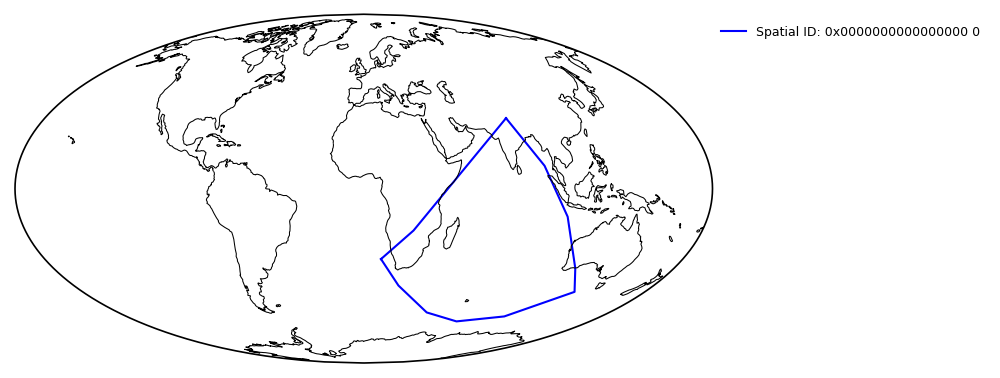

In [3]:
# Create a figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=USR_SET_GLOBAL, 
                                      show_fig=False, plot_options=usr_plot_options))

# STARE Spatial Index Value, geolocation bits are 0, resolution level is 0.
siv = 0
#print(f"Spatial ID: {hex16(siv)} {siv}")


# Show a figure and clean up
usr_figax = hello_plot(spatial_index_values=[siv], color=LEGEND_COLORS[0], 
                       legend_label=f"Spatial ID: {hex16(siv)} {siv}", figax=usr_figax, verbose=False)
plt.close('all')
del usr_figax

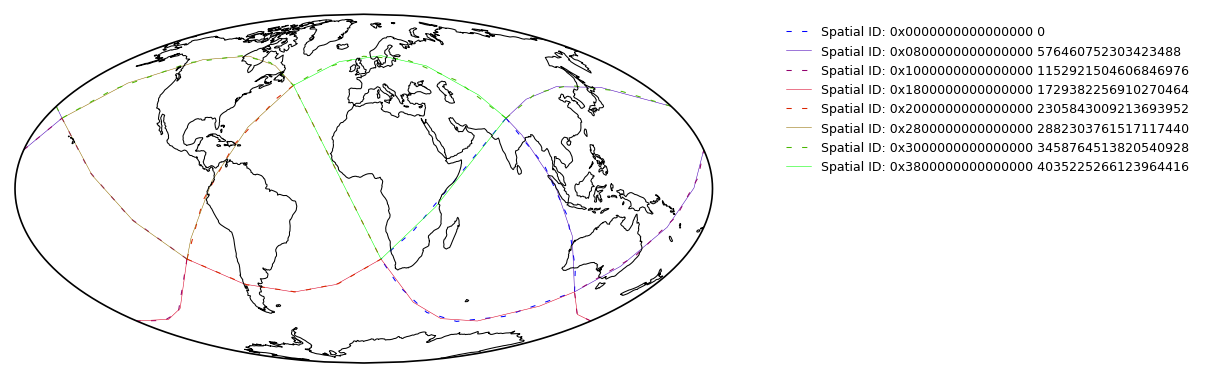

In [4]:
# level_zero_increment = 1 << 59
level_zero_increment = pystare.spatial_increment_from_level(0)

# Create a new figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=USR_SET_GLOBAL, 
                                      show_fig=False, plot_options=usr_plot_options))

# Plot each increment (overlay on common axes)
legend_info = []
n_legend_colors = 8
legend_colors = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))
for siv_idx, siv in enumerate(range(0, 8 * level_zero_increment, level_zero_increment)):
    legend_info.append(f"Spatial ID: {hex16(siv)} {siv}")
    the_dash = ((5, 10) if (siv_idx % 2) == 0 else ())
    the_lw =  (0.5 if (siv_idx % 2) == 0 else 0.25)
    if len(legend_info[0]) < 8:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], show_fig=False, lw=the_lw, use_dash=the_dash, verbose=False)
    else:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], legend_label=legend_info, show_fig=False, 
                   lw=the_lw, use_dash=the_dash, verbose=False)
plt.show()
plt.close('all')
del usr_figax   

### Not Sure

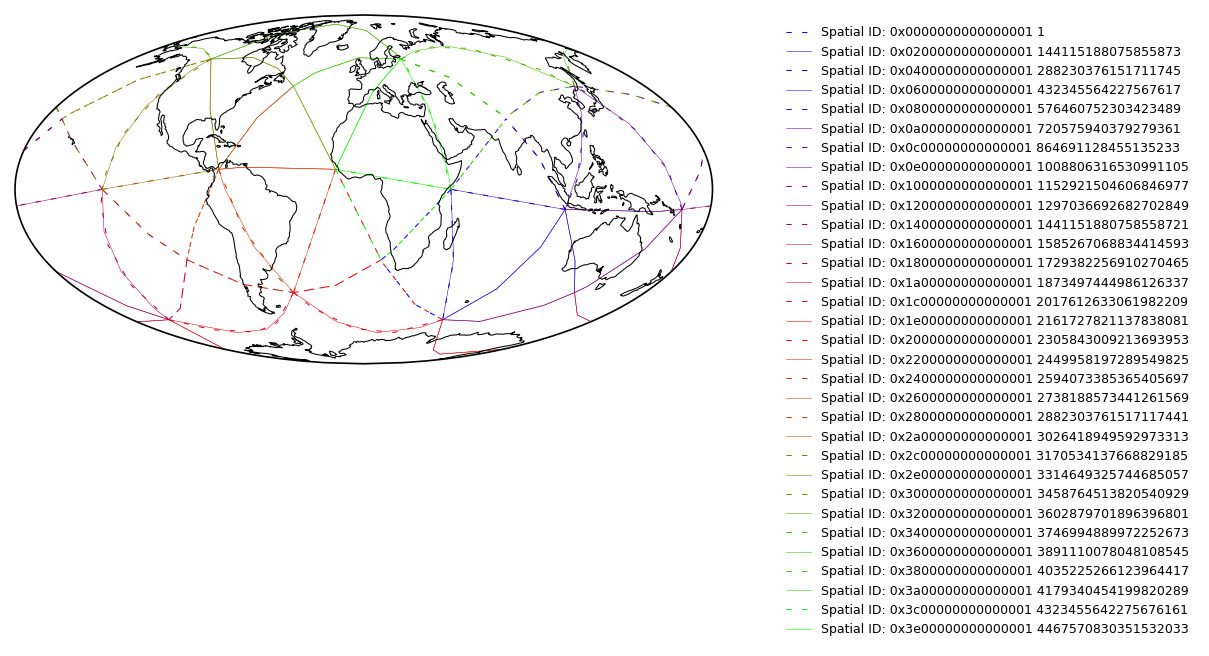

In [5]:
# level_one_increment = 1 << 57
level_one_increment = pystare.spatial_increment_from_level(1)

# Create a new figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=USR_SET_GLOBAL, 
                                      show_fig=False, plot_options=usr_plot_options))

# Plot each increment (overlay on common axes)
legend_info = []
n_legend_colors = 32
legend_colors = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))
for siv_idx, siv in enumerate(range(1, 4 * 8 * level_one_increment + 1, level_one_increment)):
    legend_info.append(f"Spatial ID: {hex16(siv)} {siv}")
    the_dash = ((5, 10) if (siv_idx % 2) == 0 else ())
    the_lw = (0.5 if (siv_idx % 2) == 0 else 0.25)
    if len(legend_info[0]) < 32:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], show_fig=False, lw=the_lw, use_dash=the_dash, verbose=False)
    else:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], legend_label=legend_info, show_fig=False, 
                   lw=the_lw, use_dash=the_dash, verbose=False)
plt.show()
plt.close('all')
del usr_figax

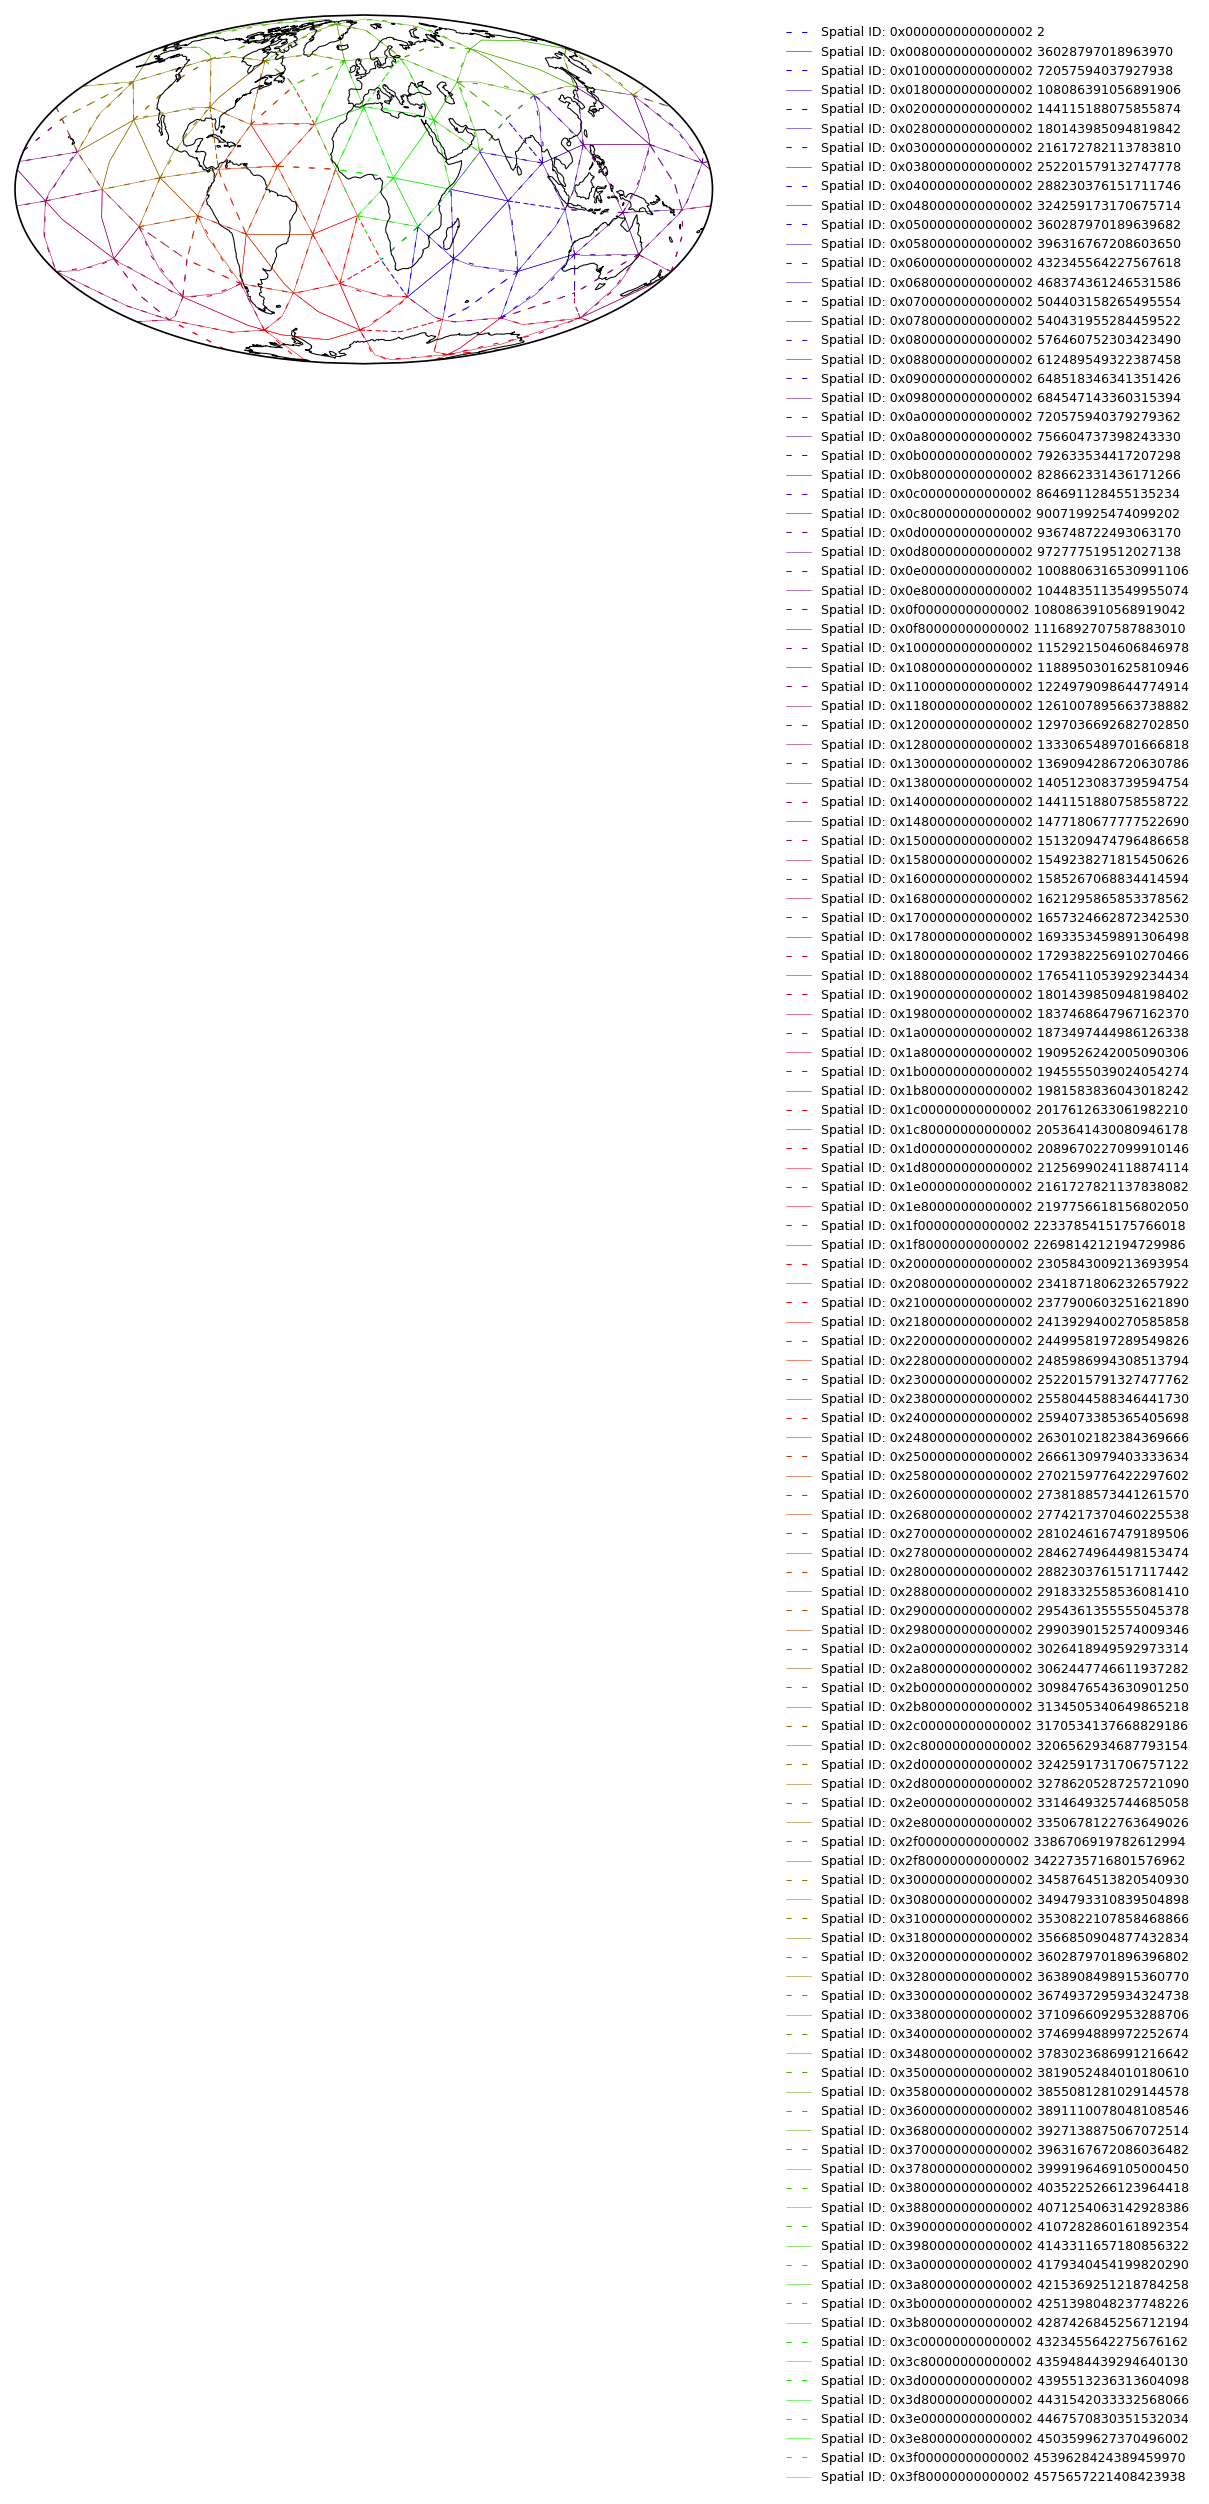

In [33]:
level = 2
level_increment = pystare.spatial_increment_from_level(level)

# Create a new figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=USR_SET_GLOBAL, 
                                      show_fig=False, plot_options=usr_plot_options))

# Plot each increment (overlay on common axes)
legend_info = []
n_legend_colors = 8*(4**level)+1
legend_colors = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))
for siv_idx, siv in enumerate(range(0, (8 * (4**level)) * level_increment, level_increment)):
    siv = siv + level # Set the level
    # print(siv_idx,siv)
    legend_info.append(f"Spatial ID: {hex16(siv)} {siv}")
    the_dash = ((5, 10) if (siv_idx % 2) == 0 else ())
    the_lw = (0.5 if (siv_idx % 2) == 0 else 0.25)
    if len(legend_info[0]) < 32:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], show_fig=False, lw=the_lw, use_dash=the_dash, verbose=False)
    else:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], legend_label=legend_info, show_fig=False, 
                   lw=the_lw, use_dash=the_dash, verbose=False)
plt.show()
plt.close('all')
del usr_figax

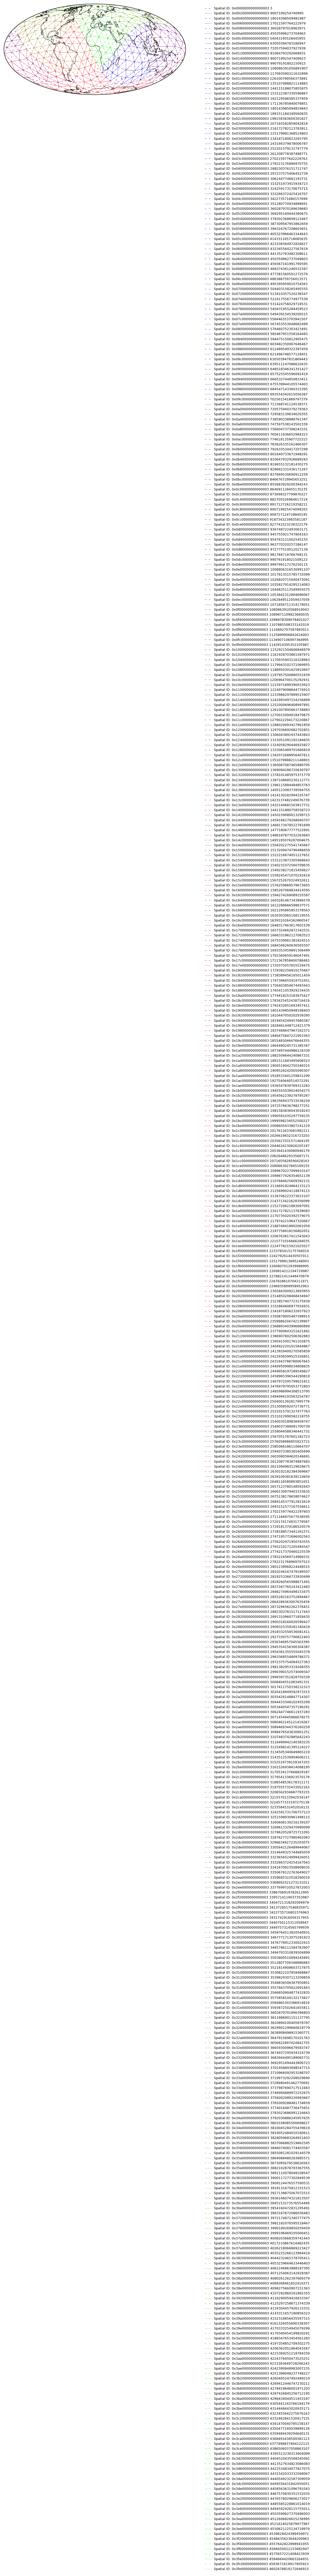

In [34]:
level = 3
level_increment = pystare.spatial_increment_from_level(level)

# Create a new figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=USR_SET_GLOBAL, 
                                      show_fig=False, plot_options=usr_plot_options))

# Plot each increment (overlay on common axes)
legend_info = []
n_legend_colors = 8*(4**level)+1
legend_colors = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))
for siv_idx, siv in enumerate(range(0, (8 * (4**level)) * level_increment, level_increment)):
    siv = siv + level # Set the level
    # print(siv_idx,siv)
    legend_info.append(f"Spatial ID: {hex16(siv)} {siv}")
    the_dash = ((5, 10) if (siv_idx % 2) == 0 else ())
    the_lw = (0.5 if (siv_idx % 2) == 0 else 0.25)
    if len(legend_info[0]) < 32:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], show_fig=False, lw=the_lw, use_dash=the_dash, verbose=False)
    else:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], legend_label=legend_info, show_fig=False, 
                   lw=the_lw, use_dash=the_dash, verbose=False)
plt.show()
plt.close('all')
del usr_figax

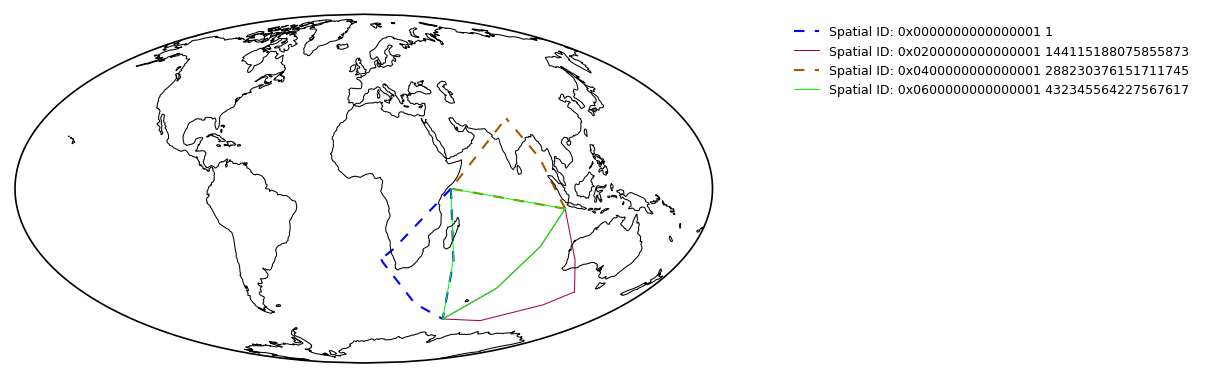

In [6]:
# level_one_increment = 1 << 57
level_one_increment = pystare.spatial_increment_from_level(1)

# Create a new figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=USR_SET_GLOBAL, 
                           show_fig=False, plot_options=usr_plot_options))

# Iterate over resolution level 1 triangles making up siv = 0.
legend_info = []
n_legend_colors = 4
legend_colors = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))
for siv_idx, siv in enumerate(range(0, 4 * level_one_increment, level_one_increment)):
    siv = siv + 1  # Set the resolution level to 1
    legend_info.append(f"Spatial ID: {hex16(siv)} {siv}")
    the_dash = ((5, 5) if (siv_idx % 2) == 0 else ())
    the_lw = (1.0 if (siv_idx % 2) == 0 else 0.5)
    if len(legend_info[0]) < 4:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], show_fig=False, lw=the_lw, use_dash=the_dash, verbose=False)
    else:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], legend_label=legend_info, show_fig=False, 
                   lw=the_lw, use_dash=the_dash, verbose=False)
plt.show()
plt.close('all')
del usr_figax

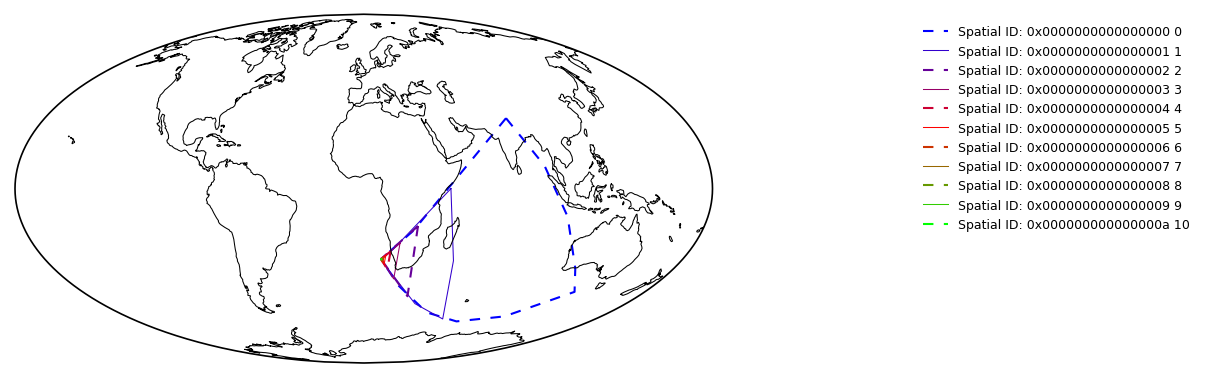

In [10]:
# Create a new figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=USR_SET_GLOBAL, 
                           show_fig=False, plot_options=usr_plot_options))

# Iterate through resolution levels
legend_info = []
finest_level = 10
n_legend_colors = finest_level+1
legend_colors = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))
for siv_idx, siv in enumerate(range(0, finest_level+1, 1)):
    legend_info.append(f"Spatial ID: {hex16(siv)} {siv}")
    the_dash = ((5, 5) if (siv_idx % 2) == 0 else ())
    the_lw = (1.0 if (siv_idx % 2) == 0 else 0.5)
    if len(legend_info[0]) < 4:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], show_fig=False, lw=the_lw, use_dash=the_dash, verbose=False)
    else:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], legend_label=legend_info, show_fig=False, 
                   lw=the_lw, use_dash=the_dash, verbose=False)
plt.show()
plt.close('all')
del usr_figax

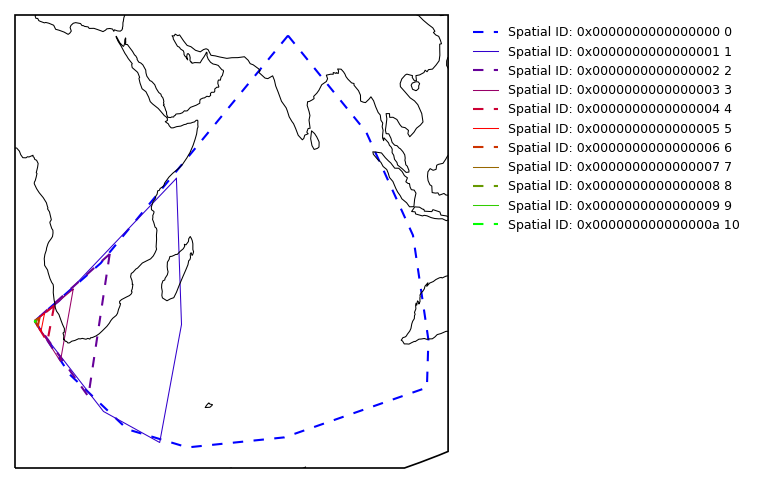

In [11]:
# Create a new figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=False, 
                           show_fig=False, plot_options=usr_plot_options))

# Iterate through resolution levels
legend_info = []
finest_level = 10
n_legend_colors = finest_level+1
legend_colors = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))
for siv_idx, siv in enumerate(range(0, finest_level+1, 1)):
    legend_info.append(f"Spatial ID: {hex16(siv)} {siv}")
    the_dash = ((5, 5) if (siv_idx % 2) == 0 else ())
    the_lw = (1.0 if (siv_idx % 2) == 0 else 0.5)
    if len(legend_info[0]) < 4:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], show_fig=False, lw=the_lw, use_dash=the_dash, verbose=False)
    else:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], legend_label=legend_info, show_fig=False, 
                   lw=the_lw, use_dash=the_dash, verbose=False)
plt.show()
plt.close('all')
del usr_figax